# Initial Assessment: SPY
In this project, we will rerun our base initial assessment workflow on SPY.
However, we will be calling the refactored functions as opposed to writing it inline. 
SPY is the NYSEARCA ticker for the SPDR S&P 500 ETF Trust.
This ETF follows the S&P 500 index with a target price of S&P500*.01 and beta=1.
This workflow uses all historical data to assess simple trend fitting, autocorrelation and
robust statistics for estimating risk and return metrics.
The goal is to identify:
* sample freq;
* sample period;
* deviation event lengths (particularly for re allocation timeframes); and
* expected returns as a function of hold time.


## Setup

In [1]:
# Paths

# Analytics dir path *USER SET*
analyticsDir = '/Users/rtasseff/projects/condor_test/analytics'
# Data dir path *USER SET*
dataDir = '/Users/rtasseff/projects/tmp'
import sys
# adding analytics to the system path
sys.path.insert(0, '/Users/rtasseff/projects/condor_test/analytics')

from data_mining import load
from functions import genStats
from functions import genFin
from functions import utils


import numpy as np
import matplotlib.pyplot as plt


## I. SPY Data 
We are using the full SPY history (1993-2024), manually downloaded.

### i. Load Price

Show pricing data by date and plot.
Here we are using the adjusted closing price as our main daily indicator.

<class 'pandas.core.frame.DataFrame'>
Index: 8091 entries, 8090 to 0
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         8091 non-null   datetime64[ns]
 1   Open         8091 non-null   object        
 2   High         7964 non-null   float64       
 3   Low          7964 non-null   float64       
 4   Close*       7964 non-null   float64       
 5   Adj Close**  7964 non-null   float64       
 6   Volume       7964 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 505.7+ KB


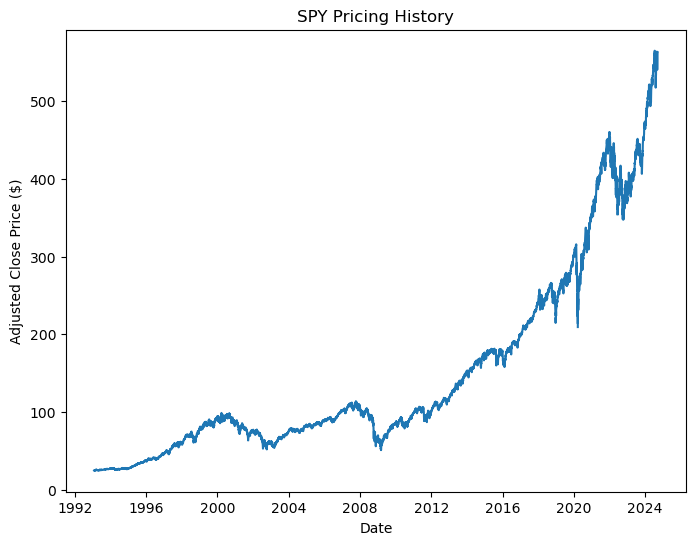


----------
Time Span: 380 months
Number of points sampled: 8091


In [2]:


# get data

dates,prices = load.assetHist_CSV(dataDir+'/spy_MAX.tab', sep='\t',assetN='SPY')
print('')
print('----------')
print('Time Span: '+str(np.datetime64(dates[-1], 'M')-np.datetime64(dates[0], 'M')))
print('Number of points sampled: '+str(len(dates)))


### ii. Caculate Returns
In the future, we will be considering many estimates over monthly relative returns.
We feel this may actually be a more important feature, vs price, 
to look at for exploring certain detials.  For example, 
in Projects 202407 and 20409 we found long term memory and high noise 
(as determined from the autocorrelation function) in the price. 
Therefore we chose to consider the returns for determining the samplining frequence.

Here we defined a month to be 21 consecutive adjusted closing day prices. 
To simplify this we are considering 30 day periods from time t to t+30 days. 
Since stock is traded when the market is open, so our time series only contains weekdays,
we are removing approximately 2 weekends days per week. 
A 30 day month, given 4.25 weeks each month, yields 8.5 weekend days.
We removed 9 days to account for a handful of holidays.
Importantly, this is consistant with 
8091 tradeing days / 380 months = 21.29 td/m
sampled in this data set.

As a matter of practice, we are considering relative returns.
 


[0.02309562 0.01971038 0.01204336 ... 0.03145524 0.03358161 0.01766503]
['1993-03-02T00:00:00.000000000' '1993-03-03T00:00:00.000000000'
 '1993-03-04T00:00:00.000000000' ... '2024-09-12T00:00:00.000000000'
 '2024-09-13T00:00:00.000000000' '2024-09-16T00:00:00.000000000']


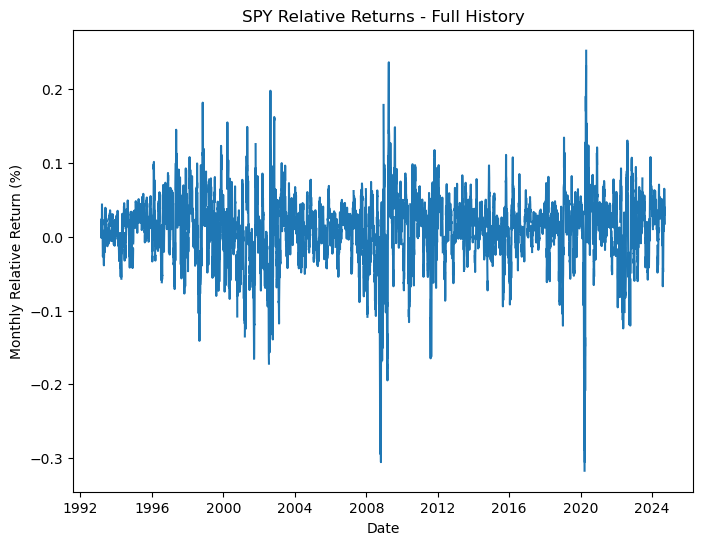

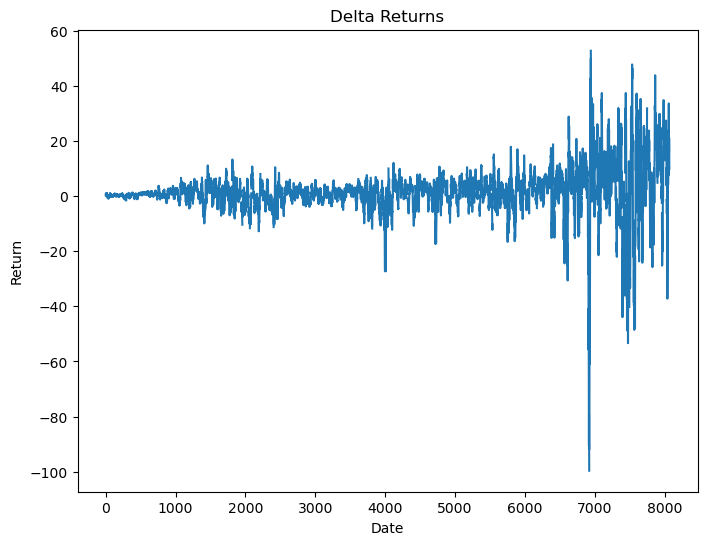

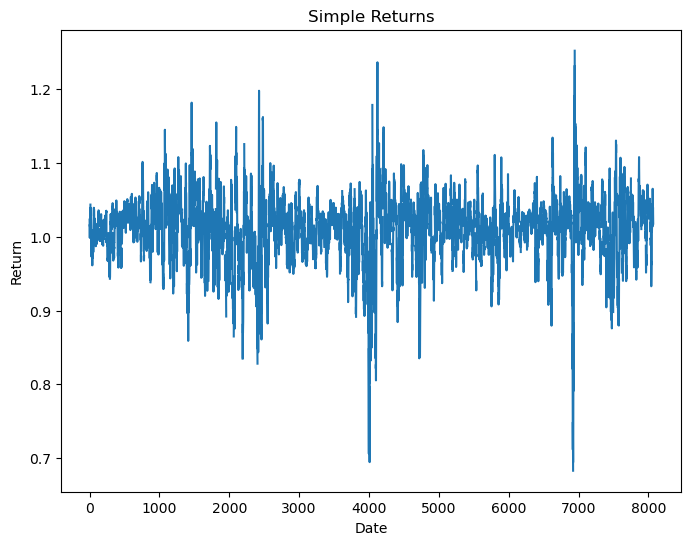

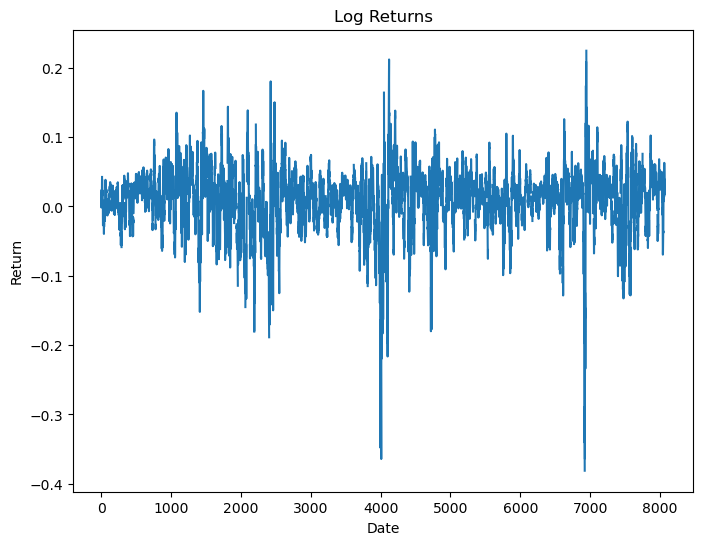

In [3]:
# conversion factor for months to consecutive points *USER SET*
month2days = 21

returns = genFin.returns(prices,period=month2days)
inds = np.arange(0,len(returns))+month2days
dates_returns = dates[inds]

# Show for sanity check
print(returns)
print(dates_returns)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(dates_returns, returns)
plt.xlabel('Date')
plt.ylabel('Monthly Relative Return (%)')
plt.title('SPY Relative Returns - Full History')
plt.show()

#Plot the non relative data for fun
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0,len(returns)), genFin.returns(prices,period=month2days,metric='Delta'))
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Delta Returns')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(np.arange(0,len(returns)), genFin.returns(prices,period=month2days,metric='Simple'))
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Simple Returns')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(np.arange(0,len(returns)), genFin.returns(prices,period=month2days,metric='Log'))
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Log Returns')
plt.show()
         

## II. Sampling Frequency 

For any statistical analysis, we have to determine how much time will pass 
between t<sub>i</sub> and <sub>i+1</sub> in our data set. 
In our experience this is often arbitrarily determined, 
but here we considered a more formal statistical approach. 
We want to maximize the number of sampling points while minimizing their dependence since a proper statistical analysis would require statistically independent samples.
We would like to select a sampling rate that minimizes the statistical dependance between data points that is driven simply by proximity in time. 
In a perfect senario this would be done by considering the elapsed time for the Auto-Correlation Function (ACF) to drop and then remain at zero. 
Of course, in any real-world data there is noise that keeps this from happening. 
In complex non-linear systems like the stock market, 
there is also the high possibility of long term memory effects as observed 
when the ACF does not approach zero or deviates from it after a period of time. 
We arbitrary chose a cutoff of +/-0.05 around the zero to be considered 'reasonably' near zero.

Previously (Project 202409), we formulated a set of rules 
to systematically select a sampling frequency from the ACF. 
First, we chose to require that the zero was within the 95% CI of the ACF value. 
This is a necessary but not a sufficient condition for being near zero. 
We also chose to require the ACF value to be within the cutoff range 
defined above as +/- 0.05. 
We went further to require the above to be true for one month, 
defined above as 21 days (i.e. 21 consecutive data points in the time course). 
Since the returns are 21 days, it stands to reason we would like our samples to be spaced such that they are nearly uncorrelated over 21 days.

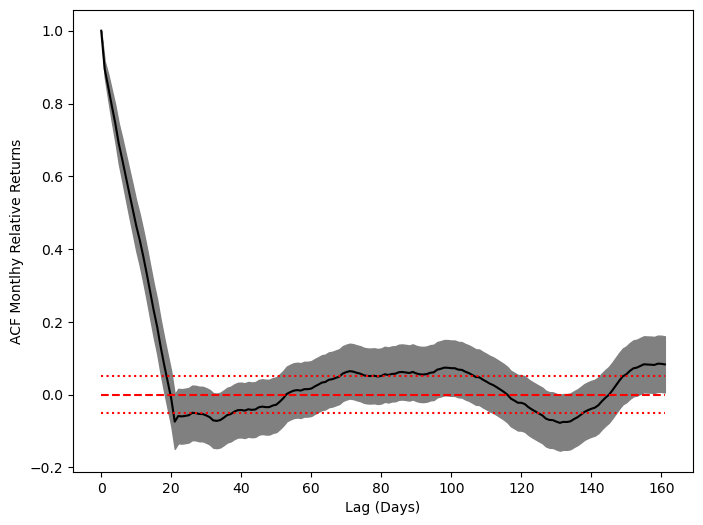

Return ACF
[ 1.          0.89426366  0.84567606  0.7949834   0.74653107  0.69035794
  0.64663535  0.60043663  0.55470037  0.50996884  0.46425479  0.42533442
  0.38073105  0.33267481  0.2811979   0.2311199   0.18586317  0.13066412
  0.0811991   0.03481252 -0.01059326 -0.07428844 -0.05882342 -0.05980196
 -0.0584155  -0.0565745  -0.04995145 -0.05072321 -0.05309142 -0.05334606
 -0.05717842 -0.06198468 -0.07083308 -0.07207861 -0.06991254 -0.06347526
 -0.0562369  -0.05331421 -0.04685941 -0.04272899 -0.0422521  -0.04395823
 -0.04022077 -0.04179346 -0.04084137 -0.03477665 -0.03288101 -0.03436587
 -0.03429932 -0.02993284 -0.02764543 -0.01943323 -0.00991464  0.00191922
  0.00699341  0.01100846  0.01244613  0.01116475  0.0149993   0.01502288]
Return ACF 95% Conf
[[ 1.00000000e+00  8.72445844e-01  8.10499842e-01  7.51185786e-01
   6.96332309e-01  6.35126679e-01  5.87438841e-01  5.37968181e-01
   4.89542573e-01  4.42600654e-01  3.95073383e-01  3.54685565e-01
   3.08873599e-01  2.59863437e-01  2.076

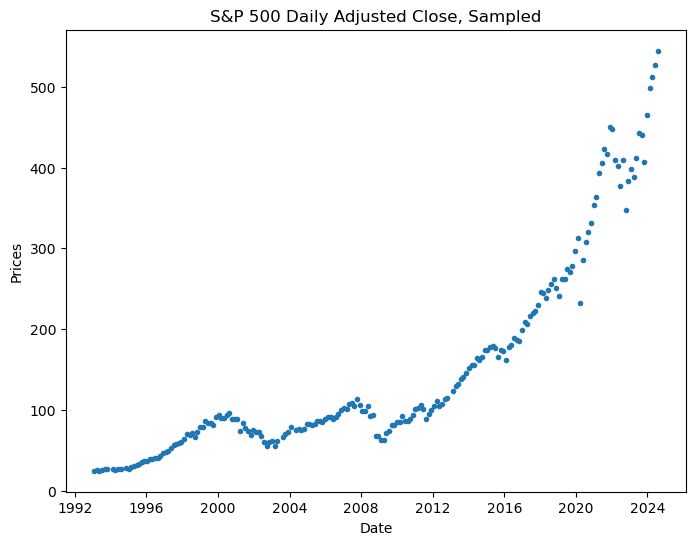

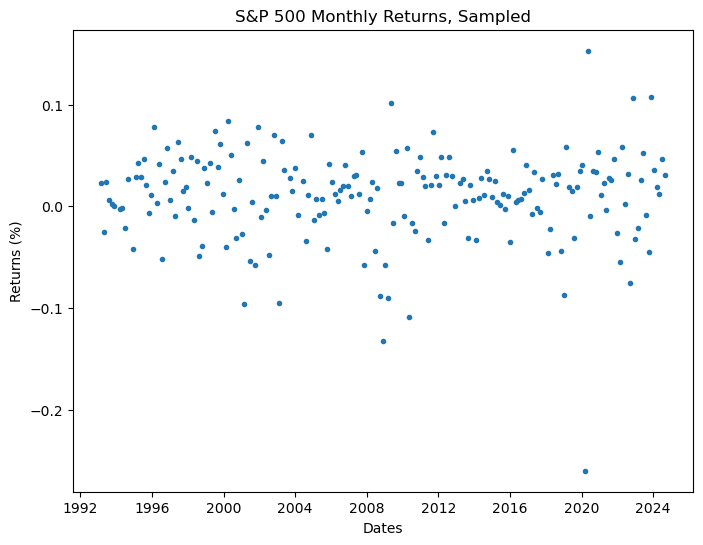

In [4]:
# +/- cutoff for 'near zero' ACF values *USER SET*
acfCutoff = 0.05

# Calc autocorr
acf_return, lag_return, acfConf_return = genStats.acf(returns,fracLag=0.02)



# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(lag_return, acf_return,color='black')
plt.plot(lag_return, lag_return*0 ,'r--') 
plt.plot(lag_return, lag_return*0 + acfCutoff,'r:') 
plt.plot(lag_return, lag_return*0 - acfCutoff,'r:') 
plt.fill_between(lag_return,acfConf_return[:,0],acfConf_return[:,1],color='gray')
plt.xlabel('Lag (Days)')
plt.ylabel('ACF Montlhy Relative Returns')
#plt.title('')
plt.show()


print('Return ACF')
print(acf_return[:60])
print('Return ACF 95% Conf')
print(acfConf_return[:60].T)


sampFreq = genStats.find_samp_freq(returns, cutoff=acfCutoff, period=month2days, fracLag=0.02)


print('Samp Freq')
print('- '+str(sampFreq))

# Parse out the proper sample data
n = len(prices)
inds = np.arange(0,n,sampFreq)
prices_samp = prices[inds]
dates_samp = dates[inds]

n = len(returns)
inds = np.arange(0,n,sampFreq)
returns_samp = returns[inds]
dates_returns_samp = dates_returns[inds]

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(dates_samp,prices_samp,'.')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.title('S&P 500 Daily Adjusted Close, Sampled')
plt.show()

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(dates_returns_samp,returns_samp,'.')
plt.xlabel('Dates')
plt.ylabel('Returns (%)')
plt.title('S&P 500 Monthly Returns, Sampled')
plt.show()


## III. Asset Deviations
Here we identified deviations in the price that were 'meaningfully'different 
from what one might expect given the 'simple' underlying trend of the data.
To do this we need to identify an underlying trend, define what is 
'meaningfully' different and identify sequental occurances of this trend.

### i. Priceing Trend 
We will be considering several 'simple' models for an underlying price trend.

Models:
* Polynomials 1-8th order
* exp function
* logrithmic function

All models were fit by manually transforming variables and then 
using the statsmodel library ordinary least squares solver.
In projects 202407 and 202409, we chose to use the maximum 
adjusted R-Squared value for the model selection criterion.
We applied the same here. 

Note that we used the modified, smaller samplied data set
for determining quantaties of a statistical nature.

#### Side Note:

Below, you will see that we found (by accedent) that scaling the x term, 
the independant variable, changes the charicteristics of the fit.
Note that we use the x term here instead of the dates for numeric reason.
The only necassary requierment for this term is that the 
x array be a sequance of evenly spaced and increasing values.
The exact value of the x's is arbitrarily determined only based only units.
This results because higher values lead to exterme differences in the RSS.
This ends up weighting the larger x values at the end of the seris.
This has consistantly lead to a poor fit at the early dates.
There is probably a more systimatic solution, 
but for our analysis we are simply scaling by the sample frequency.


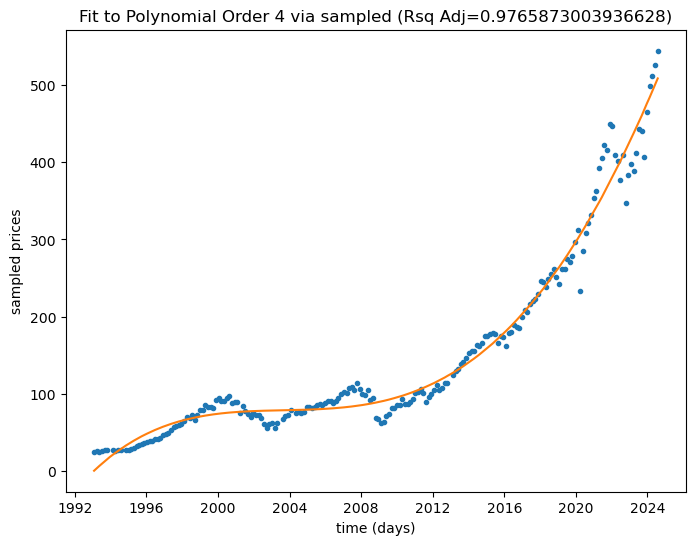

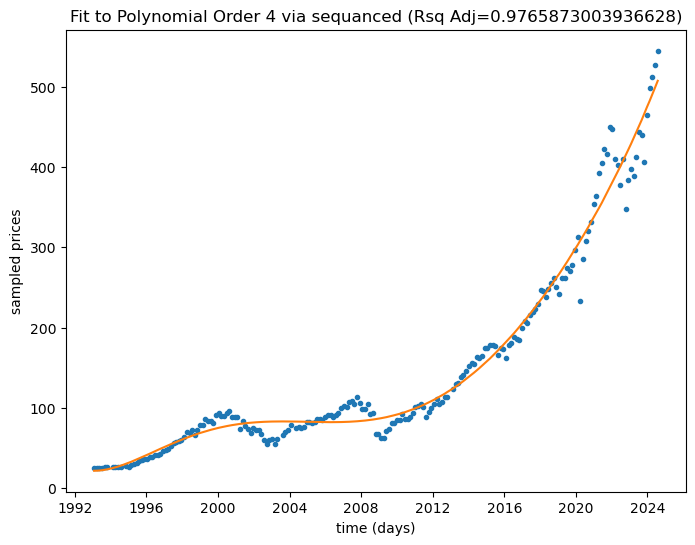

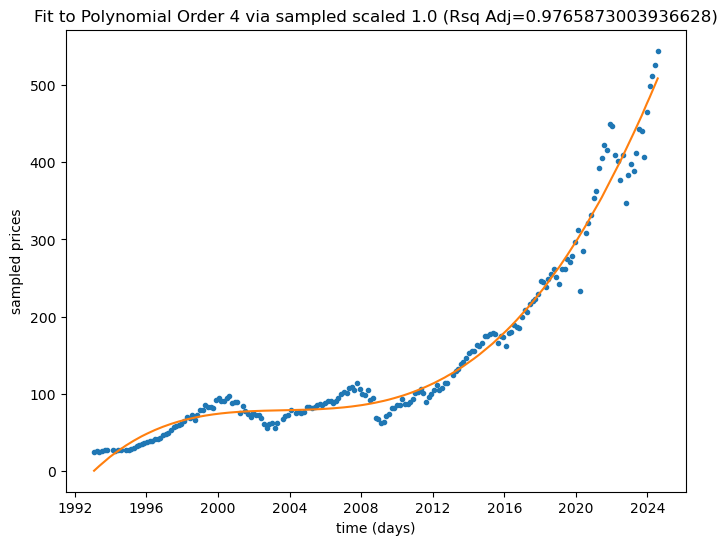

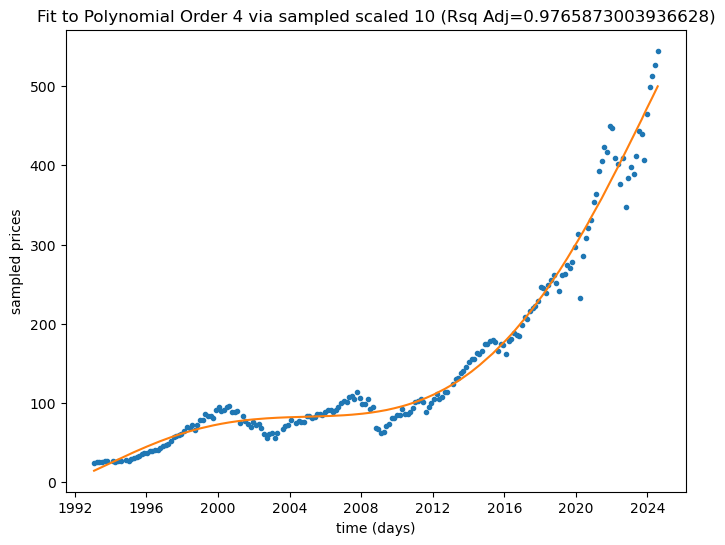

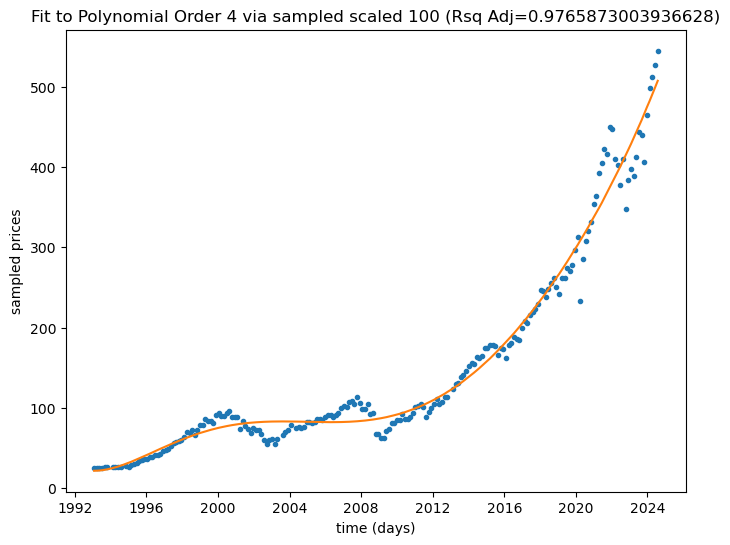

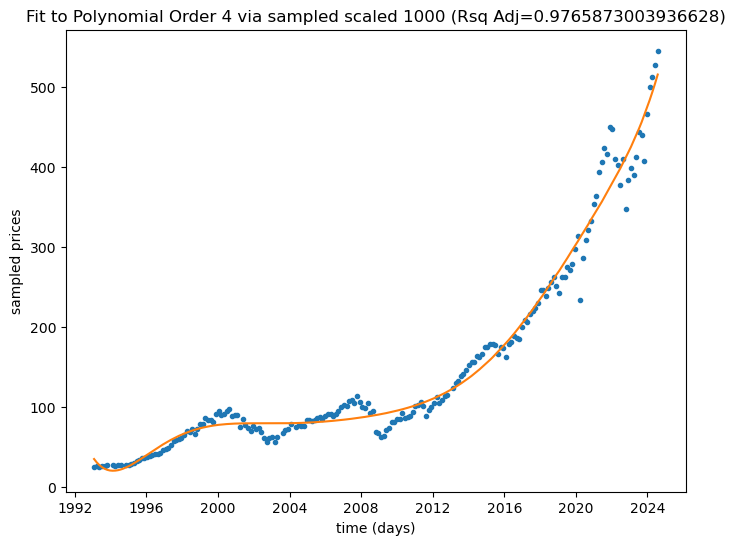

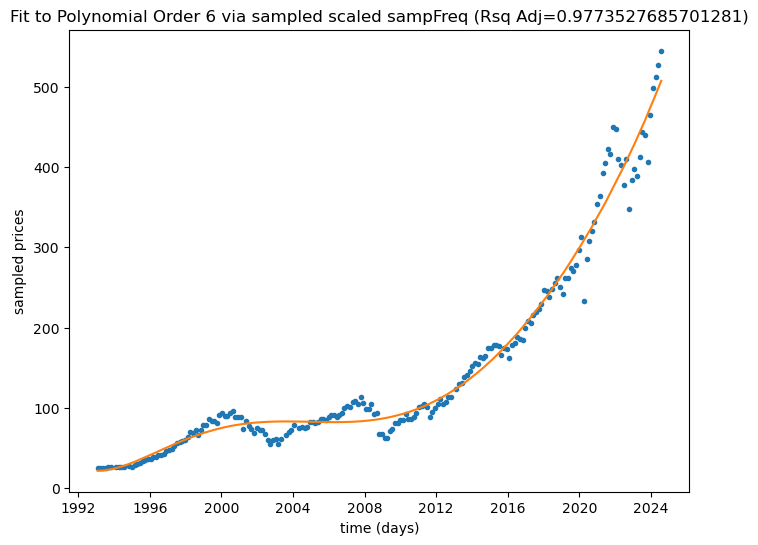

In [5]:

### fit trend line
maxPolyOrder = 8
# need consecutive numbers, not dates, values not important, evenly spaced
x = np.arange(0,len(dates),1)
x_samp = x[inds]
rsqAdj, name, model, prices_sampHat = genStats.fit_simp_model(x_samp, prices_samp, maxPolyOrder)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(dates_samp, prices_samp,'.',dates_samp,prices_sampHat,'-')
plt.xlabel('time (days)')
plt.ylabel('sampled prices')
plt.title('Fit to '+name+' via sampled (Rsq Adj='+str(rsqAdj)+')')
plt.show()


_x_samp = np.arange(0,len(dates_samp),1)
_rsqAdj, _name, _model, _prices_sampHat = genStats.fit_simp_model(_x_samp/1.0, prices_samp, maxPolyOrder)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(dates_samp, prices_samp,'.',dates_samp,_prices_sampHat,'-')
plt.xlabel('time (days)')
plt.ylabel('sampled prices')
plt.title('Fit to '+name+' via sequanced (Rsq Adj='+str(rsqAdj)+')')
plt.show()


__rsqAdj, __name, __model, __prices_sampHat = genStats.fit_simp_model(x_samp/1., prices_samp, maxPolyOrder)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(dates_samp, prices_samp,'.',dates_samp,__prices_sampHat,'-')
plt.xlabel('time (days)')
plt.ylabel('sampled prices')
plt.title('Fit to '+name+' via sampled scaled 1.0 (Rsq Adj='+str(rsqAdj)+')')
plt.show()


__rsqAdj, __name, __model, __prices_sampHat = genStats.fit_simp_model(x_samp/10., prices_samp, maxPolyOrder)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(dates_samp, prices_samp,'.',dates_samp,__prices_sampHat,'-')
plt.xlabel('time (days)')
plt.ylabel('sampled prices')
plt.title('Fit to '+name+' via sampled scaled 10 (Rsq Adj='+str(rsqAdj)+')')
plt.show()

__rsqAdj, __name, __model, __prices_sampHat = genStats.fit_simp_model(x_samp/100., prices_samp, maxPolyOrder)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(dates_samp, prices_samp,'.',dates_samp,__prices_sampHat,'-')
plt.xlabel('time (days)')
plt.ylabel('sampled prices')
plt.title('Fit to '+name+' via sampled scaled 100 (Rsq Adj='+str(rsqAdj)+')')
plt.show()

__rsqAdj, __name, __model, __prices_sampHat = genStats.fit_simp_model(x_samp/1000., prices_samp, maxPolyOrder)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(dates_samp, prices_samp,'.',dates_samp,__prices_sampHat,'-')
plt.xlabel('time (days)')
plt.ylabel('sampled prices')
plt.title('Fit to '+name+' via sampled scaled 1000 (Rsq Adj='+str(rsqAdj)+')')
plt.show()

# in thory we can arbitrarily set it, but due to the numerics of 
# the OLS solver, it seems like this scaling prevents wierdness
# in how the early dates are fit (some weighting issue)
xScaleFact = sampFreq
x_samp = x_samp/xScaleFact
# for future sake need to keep these treated the same
x4Fit = x/xScaleFact

rsqAdj, name, model, prices_sampHat = genStats.fit_simp_model(x_samp, prices_samp, maxPolyOrder)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(dates_samp, prices_samp,'.',dates_samp,prices_sampHat,'-')
plt.xlabel('time (days)')
plt.ylabel('sampled prices')
plt.title('Fit to '+name+' via sampled scaled sampFreq (Rsq Adj='+str(rsqAdj)+')')
plt.show()


We found an excelent fit with a poly order 6.
At first there was concern because Project 202409 suggested a Polynomial of order 4,
which was consistant with the findings of the actual, longer, 
S&P 500 time seris we found in Project 202407.
Upon review, we found the previous study used a diffeent sampiling frequency -
not the once specific to SPY with the most updated rules.
There was also a small issue in the code which could have also led to a 
slightly different processing of the data.
In any case, poly order 6 fits the start and terminus of the data well
(i.e. no tailing effect as seen in the other studies).

### ii. Define Deviations
We considered the price to be based on both a 'drift' and a 'noise' term.
In a perfect world, the drift would be defined by the trend and 
the noise by a uniformly distributed independnat random variable.
However (and as expected), there are clear deviations away from and 
back to the trend line over meaningfully long periods.
These are also easy to link to particular market events known to effect
the overall US economy.
In Project 202410, we chose to purse these further as abnormal deviations events.
We did the same here by considering the dispersion around the trend line
and the prices that are abnormally high or low.
Specifcally, we considered the possibility +/- 
one standard deviation (normality assumption),
the Median Absolute Deviation (MAD; corrected to match stdev under normality),
and the upper 32 percentile (corrisponds with st dev under normallity with large n)
as a definition for abnormal price behaviour.



Dispersions
----------------
method --- value
----------------
MAD --- 0.12727012971871252
Quant --- 0.11853710068296168
Normal --- 0.1258472350778368


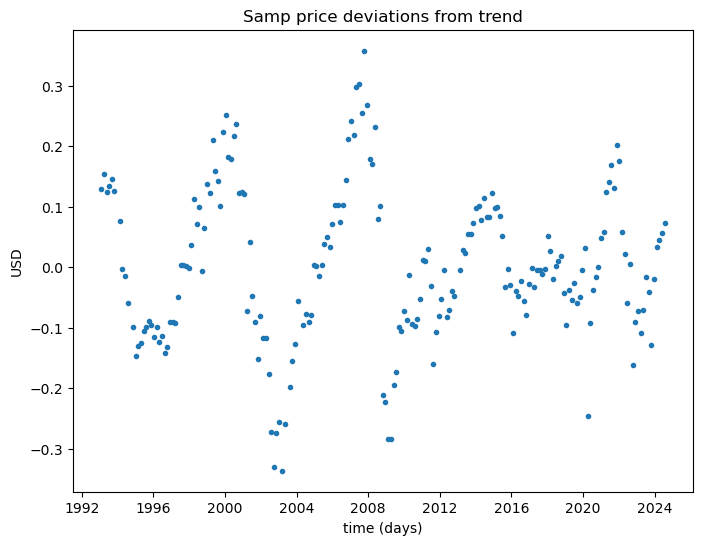

In [6]:
# consider deviations
methods = ['MAD','Quant','Normal']
sigmas = []

# get deviations
devs = genFin.dev(prices_samp,prices_sampHat)

print('Dispersions')
print('----------------')
print('method --- value')
print('----------------')

for method in methods:
    sigma = genStats.disper(devs,method=method)
    sigmas.append(sigma)
    print(method+' --- '+str(sigma))


# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(dates_samp, devs,'.')
plt.xlabel('time (days)')
plt.ylabel('USD')
plt.title('Samp price deviations from trend')
plt.show()



### iii. Identify Deviation Events
We defined a deviation event as a sequence of consecutive price
deviations that stay above the abnormal deviation threshold.
This period, in total, would be one deviation event of some period length.

Note: unlike the statistical tests where we used the sampled data, 
here we used the full data set.
This is because we do not need the data set to be independently distributed.
In fact, we are in some sense suggesting that there is a dependance 
between the prices in a given event period.
This is somewhat related to the observations of long-term price memory 
in other projects and why we had to base sampiling on the return.

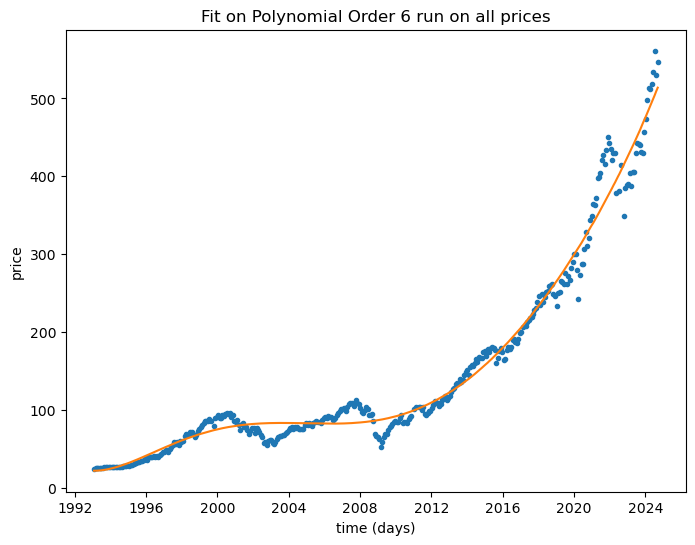

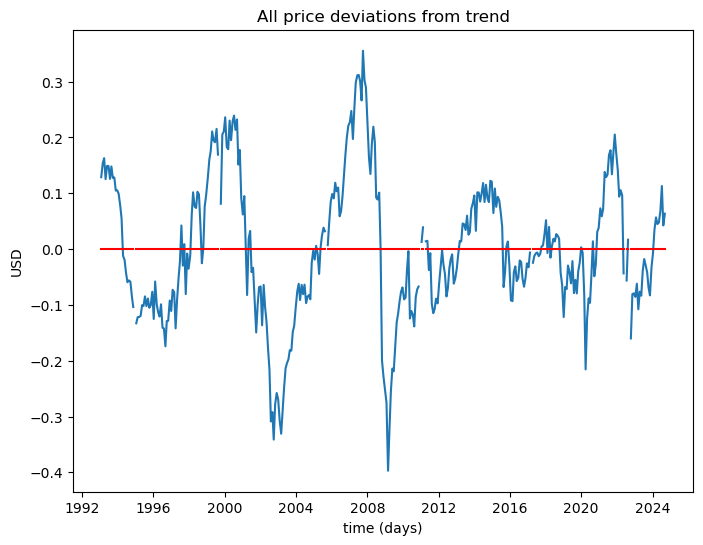

Threshold: 0.12727012971871252
Method: MAD
Number of Events: 17
Expected Event Length (M): 4.238095238095238
Abnormal Event Length (M): 8.474101576682672
Rare Event Length (M): 16.94611425385754
Crazy Event Length (M): 25.418126931032408
Event Lengths:
[ 29.  29.  29.  30.  31.  31.  32.  61.  89.  90. 148. 235. 297. 330.
 388. 597. 659.]
Total Time:
3105.0


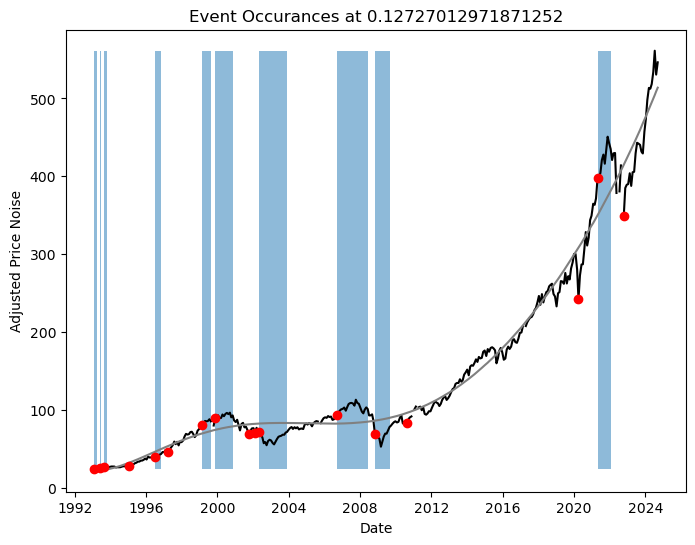

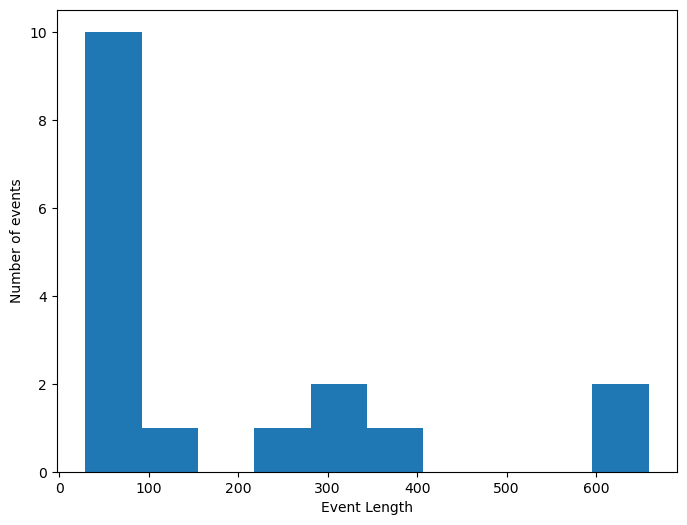

Threshold: 0.11853710068296168
Method: Quant
Number of Events: 21
Expected Event Length (M): 2.9523809523809526
Abnormal Event Length (M): 12.714285714285715
Rare Event Length (M): 32.23809523809524
Crazy Event Length (M): 51.76190476190476
Event Lengths:
[ 28.  29.  29.  29.  29.  30.  30.  31.  31.  32.  62.  63. 119. 148.
 267. 297. 298. 330. 388. 597. 659.]
Total Time:
3526.0


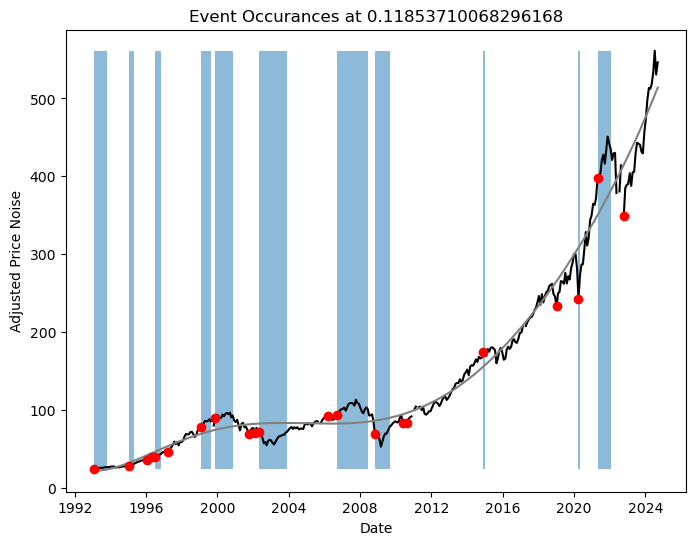

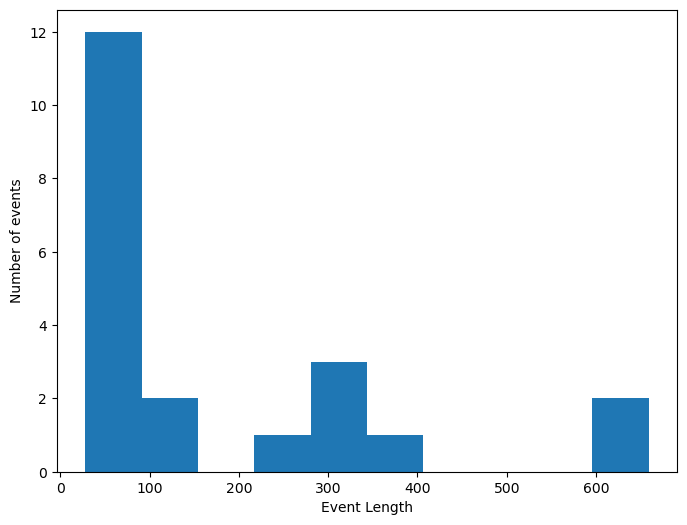

Threshold: 0.1258472350778368
Method: Normal
Number of Events: 17
Expected Event Length (M): 8.787114845938376
Abnormal Event Length (M): 18.302364747972565
Rare Event Length (M): 37.332864552040945
Crazy Event Length (M): 56.363364356109315
Event Lengths:
[ 29.  29.  29.  30.  31.  31.  32.  61.  89.  90. 148. 267. 297. 330.
 388. 597. 659.]
Total Time:
3137.0


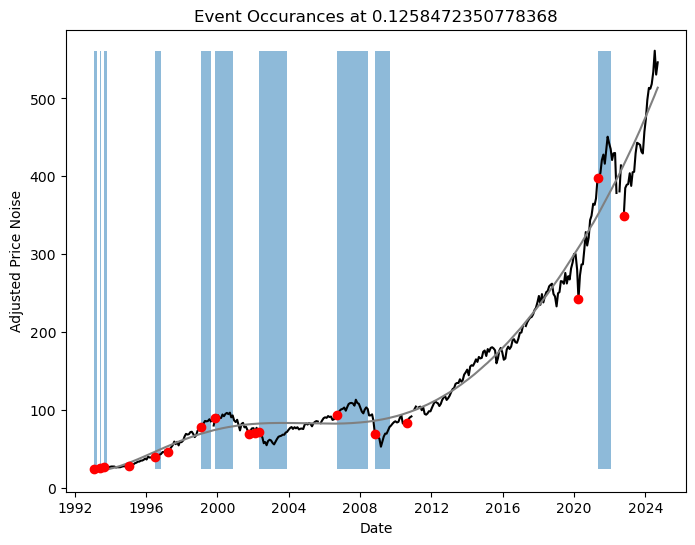

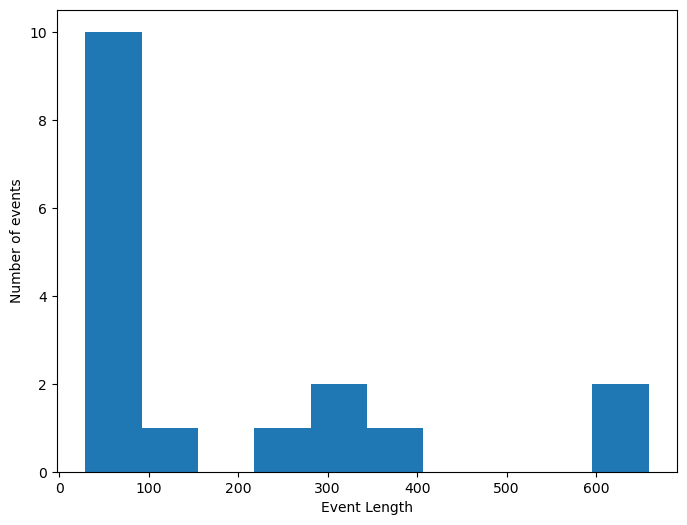

In [15]:
# first we need the trend for the whole data set

# get values
pricesHat = model.predict(genStats.x2X(x4Fit,name))

# get the disiered subset
n=len(dates)
inds=np.arange(0,n,month2days)
x=dates[inds]
y=prices[inds]
yHat=pricesHat[inds]



# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x, y,'.',x,yHat,'-')
plt.xlabel('time (days)')
plt.ylabel('price')
plt.title('Fit on '+name+' run on all prices')
plt.show()

devs = genFin.dev(y,yHat)
absDevs = np.abs(devs)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x, devs)
plt.plot(x, devs*0,'-r')
plt.xlabel('time (days)')
plt.ylabel('USD')
plt.title('All price deviations from trend')
plt.show()
    

# Cycle through metrics for deviations
n = len(sigmas)
for i in range(n):

    method = methods[i]
    thresh = sigmas[i]
    
    # flag deviations for this metric
    eventInd, eventTime, eventLength = genFin.flag_dev_event(x,y,yHat,thresh)

    # need floats not timedelays for some processing
    eventDays=utils.ns2days(eventLength)
    
    print('Threshold: '+str(thresh))
    print('Method: '+method)
    print('Number of Events: '+str(len(eventTime)))
    if method=='Normal':
        eventExp = np.mean(eventDays)/month2days
    else:
        eventExp = np.median(eventDays)/month2days
    print('Expected Event Length (M): '+str(eventExp))
    eventDisper = genStats.disper(eventDays,method)/month2days
    print('Abnormal Event Length (M): '+str(eventExp+eventDisper))
    print('Rare Event Length (M): '+str(eventExp+3*eventDisper))
    print('Crazy Event Length (M): '+str(eventExp+5*eventDisper))
    print('Event Lengths:')
    print(np.sort(eventDays))
    print('Total Time:')
    print(np.sum(eventDays))
    inds = np.array(eventInd)
    
    # Plot the data
    plt.figure(figsize=(8, 6))
    plt.plot(x, y,color='black')
    plt.plot(x, yHat,color='gray')
    plt.plot(x[eventInd],y[eventInd],'or')

    plt.fill_between(x, min(y), max(y), where=(absDevs > thresh), alpha=0.5)
    plt.xlabel('Date')
    plt.ylabel('Adjusted Price Noise')
    plt.title('Event Occurances at ' + str(thresh))
    plt.show()

    
    plt.figure(figsize=(8, 6))
    plt.hist(eventDays)
    plt.xlabel('Event Length')
    plt.ylabel('Number of events')
    plt.title('')
    plt.show()




Lots of cool stuff between 
Robust and Normal
Days (swing) vs Months (convention) vs SampFreq (stats)